In [1]:
%pylab inline
from rpyc import connect
#from PyRedPitaya.pc import RedPitaya
from PyRedPitaya.client_memory import ClientMemory
from PyRedPitaya.memory import MemoryInterface
from PyRedPitaya.enum import Enum
from PyRedPitaya.instrument import *
import time
REDPITAYA_IP = '192.168.14.175'

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.width'] = 1
import h5py

fig_lett_font = {'fontname':'Helvetica'}

color_list = ['#0066CC','#00974F','#CC0000','#FF7F00']

mpl.rcParams['axes.color_cycle'] = color_list

** UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


In [3]:
from slab.instruments.awg.PXDAC4800 import PXDAC4800

** ShimWarning: The `IPython.qt` package has been deprecated. You should import from qtconsole instead.


Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LabBrick Gui
Could not load labbrick
DSFIT could not import guiqwt


In [4]:
global PXDAC4800

In [5]:
class Scope2(MemoryInterface):
    data_length = 2**13
    def __init__(self, addr_base = 0x40100000, channel='A', **kwd):
        kwd["addr_base"] = addr_base
        super(Scope2, self).__init__(**kwd)

    writestate_machine_bit = GetSetBit(addr=0x0, pos=1)
    trigger_bit =  GetSetBit(addr=0x0, pos=0)

    def reset_writestate_machine(self,v=True):
        self.writestate_machine_bit = v

    def arm_trigger(self,v=True):
        self.trigger_bit = v

    trigger_source = GetSetRegister(0x4, TriggerSource())
    threshold_ch1 = GetSetRegister(0x8, SignedInteger(size=14))
    threshold_ch2 = GetSetRegister(0xC, SignedInteger(size=14))
    trigger_delay = GetSetRegister(0x10, UnsignedInteger(size=32))
    data_decimation = GetSetRegister(0x14, Decimation())
    write_pointer_current = GetRegister(0x18, UnsignedInteger(size=14))
    write_pointer_trigger = GetRegister(0x1C, UnsignedInteger(size=14))
    hysteresis_ch1 = GetSetRegister(0x20, SignedInteger(size=14))
    hysteresis_ch2 = GetSetRegister(0x24, SignedInteger(size=14))
    average = GetSetBit(addr=0x28, pos=0)
    ss_mode = GetSetBit(addr=0x28, pos=1)
    ss_2ch  = GetSetBit(addr=0x28, pos=2)
    #equalization filter not implemented here
    dac2_on_ch1 = GetSetBit(0x50, pos=0)
    dac1_on_ch2 = GetSetBit(0x50, pos=1)
    set_deb_len = GetSetRegister(0x90, SignedInteger(size=20))

    hw_avgs = GetSetRegister(0xAC, UnsignedInteger(size=18))
    version = GetRegister(0xB0, UnsignedInteger(size=32))
    hw_avg_status = GetRegister(0xB4, UnsignedInteger(size=32))
    adc_trigged = GetSetBit(0xB4, pos=3)
    npt_mode = GetSetBit(0xB4, pos=2)
    avg_mode = GetSetBit(0xB4, pos=1)
    avg_do = GetSetBit(0xB4, pos=0)
    avg_cnt= GetRegister(0xB8, UnsignedInteger(size=18))

    abc_a_score = GetRegister(0xBC, SignedInteger(size=32))
    abc_b_score = GetRegister(0xC0, SignedInteger(size=32))
    win_start   = GetSetRegister(0xC4, SignedInteger(size=14))
    win_stop    = GetSetRegister(0xC8, SignedInteger(size=14))

    t1 = GetSetBit(0xB4, pos=4)
    t2 = GetSetBit(0xB4, pos=5)
    t3 = GetSetBit(0xB4, pos=6)
    t4 = GetSetBit(0xB4, pos=7)
    t5 = GetSetBit(0xB4, pos=8)

    #### Function specific to read the array of data
    def get_rawdata(self, addr, length = None):
        if length is None: length=self.data_length
        x = self.reads(addr, length)
        y = x.copy()
        y.dtype = np.int32
        y[y>2**31] -= 2**31
        return y

    @property
    def rawdata_ch1(self):
        return self.get_rawdata(0x10000)

    @rawdata_ch1.setter
    def rawdata_ch1(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x10000, data)

    @property
    def rawdata_ch2(self):
        return self.get_rawdata(0x20000)

    @rawdata_ch2.setter
    def rawdata_ch2(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x20000, data)

    @property
    def data_ch1(self):
        return np.roll(self.rawdata_ch1,-int(self.write_pointer_trigger))
    @property
    def data_ch2(self):
        return np.roll(self.rawdata_ch2,-int(self.write_pointer_trigger))

    @property
    def conv11_data(self):
        return np.array([self.to_pyint(v) for v in self.reads(0x30000, self.data_length)])

    @conv11_data.setter
    def conv11_data(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x30000, data)

    @property
    def conv12_data(self):
        return np.array([self.to_pyint(v) for v in self.reads(0x40000, self.data_length)])

    @conv12_data.setter
    def conv12_data(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x40000, data)

    @property
    def conv21_data(self):
        return np.array([self.to_pyint(v) for v in self.reads(0x50000, self.data_length)])

    @conv11_data.setter
    def conv21_data(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x50000, data)

    @property
    def conv22_data(self):
        return np.array([self.to_pyint(v) for v in self.reads(0x60000, self.data_length)])

    @conv12_data.setter
    def conv22_data(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x60000, data)

    def set_conv22_data(self, data):
        data = [self.from_pyint(v) for v in data]
        self.writes(0x60000, data)

    # helpers
    @property
    def times(self):
        return np.linspace(0.0,8e-9*self.data_decimation*float(self.data_length),self.data_length,endpoint=False)

    def setup_trigger(self, trigger_source=TriggerSource.immediately, threshold_ch1=0,threshold_ch2=0):
        self.threshold_ch1 = threshold_ch1
        self.threshold_ch2 = threshold_ch2
        self.trigger_source = trigger_source
        self.set_deb_len = 1000


    def acquire_avg(self, samples, avgs=1):
        self.reset_writestate_machine(v=True)
        self.trigger_delay = samples  # self.data_length
        self.dac1_on_ch2 = False
        self.dac2_on_ch1 = False
        self.data_decimation = 1
        self.arm_trigger(v=False)
        self.average = False
        #self.trigger_source = trigger_source
        self.hw_avgs = avgs
        self.ss_mode = False

        self.reset_writestate_machine(v=False)
        self.arm_trigger()

        while (self.avg_cnt < avgs):
            time.sleep(1E-3)

        return self.get_rawdata(0x10000, length = samples)/ max(1, self.avg_cnt), self.get_rawdata(0x20000, length = samples) / max(1, self.avg_cnt)

    def acquire_singleshot(self, samples, start=0, stop=None, shots=1, dual_ch=False, use_filter=False, start_function = None, prep_function = None):

        if not prep_function == None:
            prep_function()

        if stop is None: stop = samples
        shot_data_ch1 = np.zeros(shots,dtype=long)
        if dual_ch: shot_data_ch2 = np.zeros(shots,dtype=long)
        shots_read=0
        loops=0
        data_length=self.data_length


        self.reset_writestate_machine(v=True)
        self.trigger_delay = samples
        self.dac1_on_ch2 = False
        self.dac2_on_ch1 = False
        self.data_decimation = 1
        self.arm_trigger(v=False)
        self.average = False
        if not use_filter: self.setup_convolution_filter()
        self.hw_avgs = shots
        self.ss_mode = True
        self.ss_2ch = dual_ch
        self.win_start = start
        self.win_stop = stop

        ch1_address=0x10000
        ch2_address=0x20000

        self.reset_writestate_machine(v=False)
        self.arm_trigger()

        print "###########################"
        print "sleeping 0.1s!"
        time.sleep(0.1)
        print "###########################"

        if not start_function == None:
            start_function()

        cnt=self.avg_cnt
        while (cnt < shots or shots_read < cnt):
            if cnt - shots_read > data_length:
                print "Overflow after %d shots, with %d shots read!" % (cnt, shots_read)
                break
            mem_start=4*(shots_read % data_length)
            read_length = cnt - shots_read


            shot_data_ch1[shots_read:shots_read+read_length] = array(self.reads(ch1_address+mem_start, read_length),copy=True,dtype=int32)
            if dual_ch:
                shot_data_ch2[shots_read:shots_read+read_length] = array(self.reads(ch2_address+mem_start, read_length),copy=True,dtype=int32)

            shots_read += read_length

            loops+=1
            #if loops % 2**11 ==0: print "x",
            #print "loops: %d, cnt: %d, shots_read: %d, start: %d, length: %d" % (loops,cnt,shots_read,start,read_length)

            cnt=self.avg_cnt

        if dual_ch:
            return shot_data_ch1, shot_data_ch2
        else:
            return shot_data_ch1

    def setup_convolution_filter(self, xg=None,yg=None, xe=None,ye=None):
        if xg is None or yg is None or xe is None or ye is None:
            self.writes(0x30000, np.zeros(self.data_length).astype('int16'))
            self.writes(0x40000, np.zeros(self.data_length).astype('int16'))
            self.writes(0x50000, (np.ones(self.data_length)).astype('int16'))
            self.writes(0x60000, (np.ones(self.data_length)).astype('int16'))
            print "clear conv buffer"
        else:
            self.writes(0x30000, ((xg+xe)/2).astype('int16'))
            self.writes(0x40000, ((yg+ye)/2).astype('int16'))
            self.writes(0x50000, (xe-xg).astype('int16'))
            self.writes(0x60000, (ye-yg).astype('int16'))


    def setup(self,frequency=1,trigger_source=TriggerSource.immediately):
        self.reset_writestate_machine(v=True)
        self.trigger_delay = self.data_length
        self.dac1_on_ch2 = False
        self.dac2_on_ch1 = False
        self.arm_trigger(v=False)
        self.average = True
        self.frequency = frequency
        self.trigger_source = trigger_source
        self.reset_writestate_machine(v=False)
        self.arm_trigger()

    def rearm(self,frequency=None,trigger_source = 8):
        if not frequency is None:
            self.frequency = frequency
        self.trigger_delay = self.data_length
        self.trigger_source = trigger_source
        self.arm_trigger()

    @property
    def frequency(self):
        return 1.0/float(self.data_decimation)/float(self.data_length)/8e-9

    @frequency.setter
    def frequency(self, v):
        fbase = 125e6/float(2**14)
        factors = [1,8,64,1024,8192,65536,65537]
        for f in factors:
            if v > fbase/float(f):
                self.data_decimation = f
                break
            if f == 65537:
                self.data_decimation = 65536
                print "Frequency too low: Impossible to sample the entire waveform"

def plot_trajectory(x,y,cmap='winter'):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap(cmap),
                        norm=plt.Normalize(0, 1))
    lc.set_array(linspace(0,1,len(x)))
    lc.set_linewidth(1)

    plt.gca().add_collection(lc)
    maxval=max(max(abs(x)),max(abs(y)))
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)

def rotate_xy(x,y,angle):
    return cos(angle)*x-sin(angle)*y,sin(angle)*x+cos(angle)*y

class RedPitaya(ClientMemory):
    hk = InterfaceDescriptor(HK)
    ams = InterfaceDescriptor(AMS)
    scope = InterfaceDescriptor(Scope2)
    pid11 = InterfaceDescriptor(Pid,number='11')
    pid12 = InterfaceDescriptor(Pid,number='12')
    pid21 = InterfaceDescriptor(Pid,number='21')
    pid22 = InterfaceDescriptor(Pid,number='22')
    asga = InterfaceDescriptor(ASG,channel='A')
    asgb = InterfaceDescriptor(ASG,channel='B')

In [6]:
conn = connect(REDPITAYA_IP, port=18861)
redpitaya = RedPitaya(conn)
rp=redpitaya

print "FPGA code version: %d" % rp.scope.version

FPGA code version: 56


In [7]:
PXDAC4800().load_sequence_file(r"S:\_Data\161117 - Redpitaya Dev\data\../sequences/Rabi.rd16"
                               , [-350, -1800],1.2)
## change this to the appropriate wavelength!
PXDAC4800.waveform_length = 16384

load_sequence_file inputs:
S:\_Data\161117 - Redpitaya Dev\data\../sequences/Rabi.rd16
[-350, -1800]
1.2
DPXDAC4800.dll loaded
Connecting to PXDAC4800 device.
PXDAC4800 device connected.
Getting Serial Number.
Serial Number: 301483
Setting DAC
Active Channel Mask: 3
Load waveform file.
Loading..
Loaded!
Playback Bytes: 131072


In [8]:
from slab.instruments.pulseblaster.pulseblaster import *
pb_init()

spinapi64 DLL loaded!


0

In [9]:
def stop_awg():
    pb_stop()
    PXDAC4800().stop()

def run_awg():
    PXDAC4800().run_experiment()
    time.sleep(0.1)
    pb_start()

In [10]:
samples=500
shots=100
rp.scope.setup_trigger (trigger_source=6, threshold_ch1 = 2000, threshold_ch2 = 2000)

In [11]:




stop_awg()
run_awg()
ch1, ch2 = rp.scope.acquire_avg (samples = samples, avgs = shots)
stop_awg()

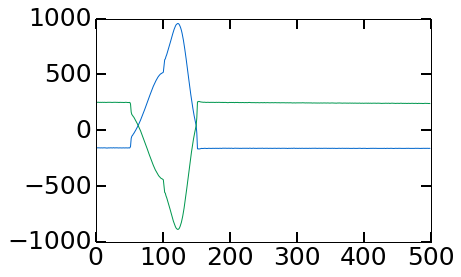

In [12]:
plt.plot(ch1)
plt.plot(ch2)

In [13]:
start = 10
stop = 200

shot_data1,shot_data2 = rp.scope.acquire_singleshot (samples = samples, start = start, stop = stop, shots = shots, dual_ch=True
                                                         , use_filter=False, start_function= run_awg, prep_function = stop_awg)

clear conv buffer
###########################
sleeping 0.1s!
###########################


** DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
** DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


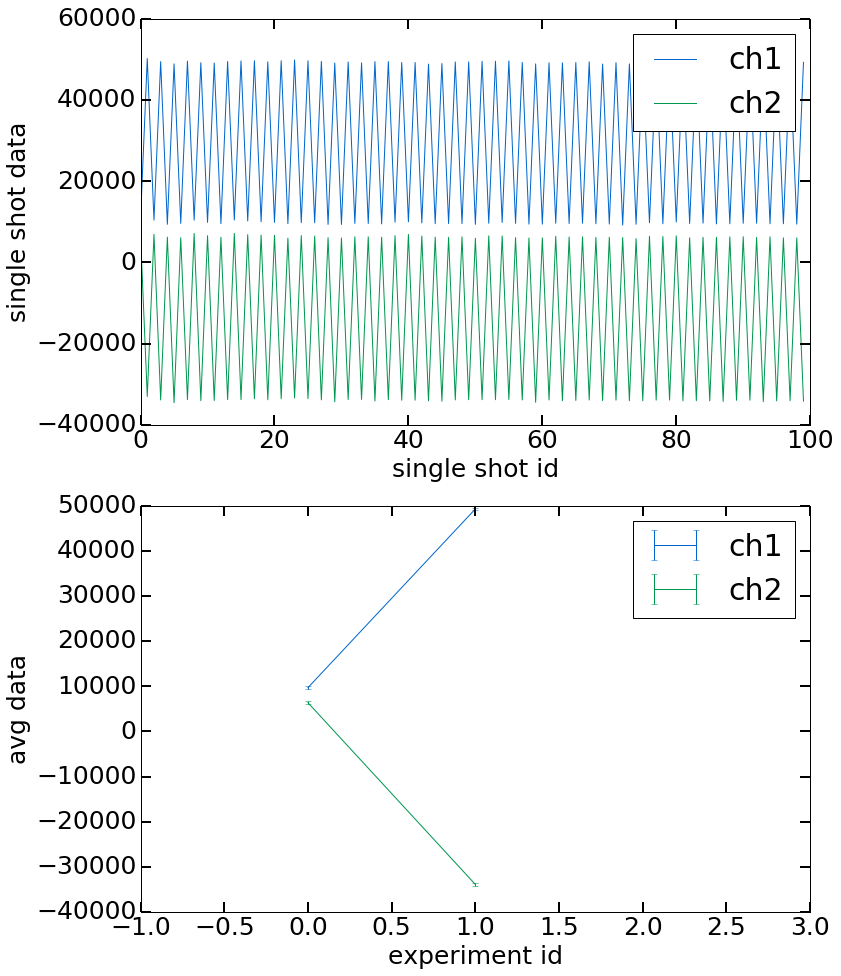

In [14]:
fig = pyplot.figure(figsize=(12,16))


num_experiments = 2

data_crop1 = shot_data1[0:math.floor(shots/num_experiments)*num_experiments]
data_crop1_matrix = np.reshape(data_crop1, (-1, num_experiments))

data_crop1_avg = np.mean(data_crop1_matrix, axis=0)
data_crop1_std = np.std(data_crop1_matrix, axis=0)

data_crop2 = shot_data2[0:math.floor(shots/num_experiments)*num_experiments]
data_crop2_matrix = np.reshape(data_crop2, (-1, num_experiments))

data_crop2_avg = np.mean(data_crop2_matrix, axis=0)
data_crop2_std = np.std(data_crop2_matrix, axis=0)

ax  = fig.add_subplot(211)

ax.plot (shot_data1,label='ch1')
ax.plot (shot_data2,label='ch2')
ax.legend()
ax.set_ylabel('single shot data')
ax.set_xlabel('single shot id')

#print np.allclose(shot_data1,shot_data2)

ax  = fig.add_subplot(212)
ax.errorbar(arange(num_experiments),data_crop1_avg,yerr=data_crop1_std,label='ch1')
ax.errorbar(arange(num_experiments),data_crop2_avg,yerr=data_crop2_std,label='ch2')
ax.set_xlim(-1,num_experiments+1)
ax.legend(loc=0)
ax.set_ylabel('avg data')
ax.set_xlabel('experiment id')

In [15]:
np.save("data/161221-shot_data1-shots-1000-samples-500-start-10-stop-200-rabi-a-0.2-start-100-step-1-stop-200-gauss-phase-45",shot_data1)
np.save("data/161221-shot_data2-shots-1000-samples-500-start-10-stop-200-rabi-a-0.2-start-100-step-1-stop-200-gauss-phase-45",shot_data2)